In [11]:
# importing modules
from torch import nn, optim
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms # datasets for default datasets
from torchvision.io import read_image # for reading images from custom dataset
import numpy as np
import matplotlib.pyplot as plt



# setting device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
'''
# mounting drive and defining DATASET_PATH
from google.colab import drive
drive.mount('/content/drive')

# adding path of user defined modules to the system path to allow import
import sys
sys.path.append('/content/drive/My Drive/Project files')
'''
# importing user defined modules
'''
from dataset import BSD100DataSet, TrainSet, TestSet, DATASET_PATH
from model import DenoisingAutoencoder
'''
from ffhq_dataset import FFHQDataSet, TrainSet, TestSet, DATASET_PATH
from ffhq_model import DenoisingAutoencoder
from ffhq_utils import PSNR, imshow_side_by_side, predict, test

# changing current working directory
import os
os.chdir(DATASET_PATH)



In [37]:
import sys
!{sys.executable} -m pip install numpy
print(sys.path)

['C:\\Python 312\\python312.zip', 'C:\\Python 312\\DLLs', 'C:\\Python 312\\Lib', 'C:\\Python 312', '', 'C:\\Users\\athar\\AppData\\Roaming\\Python\\Python312\\site-packages', 'C:\\Users\\athar\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32', 'C:\\Users\\athar\\AppData\\Roaming\\Python\\Python312\\site-packages\\win32\\lib', 'C:\\Users\\athar\\AppData\\Roaming\\Python\\Python312\\site-packages\\Pythonwin', 'C:\\Python 312\\Lib\\site-packages', 'C:\\tools\\Manim\\Lib\\site-packages']


'C:\Python' is not recognized as an internal or external command,
operable program or batch file.


In [71]:
import matplotlib.pyplot as plt

In [69]:
!"C:\Python 312\python" -m pip install matplotlib


   ---------------------------------------- 0.0/8.0 MB ? eta -:--:--
   ------------- -------------------------- 2.6/8.0 MB 12.6 MB/s eta 0:00:01
   ------------------------------- -------- 6.3/8.0 MB 14.9 MB/s eta 0:00:01
   ---------------------------------------- 8.0/8.0 MB 14.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------- 2.2/2.2 MB 15.6 MB/s eta 0:00:00


In [13]:
transform = transforms.Compose([
    transforms.ToPILImage(), # important for Resize, Hflip and Vflip
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.Grayscale(),
    transforms.ToTensor()
])
TRAIN_SIZE = 1024
TEST_SIZE = 128
CHECKPOINT_PATH = "C:/Users/athar/MLprojects/dataloader_task/Denoising Autoencoder/den_autoenc.pth"

# initialise dataset
'''
dataset = BSD100DataSet(dataset_path = DATASET_PATH, transform = transform)
'''
dataset = FFHQDataSet(dataset_path = DATASET_PATH, transform = transform)
'''
# problem with slicing: train_set and test_set are no more instances of Dataset class, but rather are lists of tensor tuples - this leads to inconsistency while passing to dataloader.
# see guidelines for creating custom dataset class: https://pytorch.org/tutorials/beginner/basics/data_tutorial.html
train_set = dataset[:90]
test_set = dataset[90:]
'''
train_set = TrainSet(dataset_path = DATASET_PATH, transform = transform, size = TRAIN_SIZE)
test_set = TestSet(dataset_path = DATASET_PATH, transform = transform, size = TEST_SIZE)

# initialise train and test dataloader
batch_size = 32
train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=1,
    shuffle=False)

In [22]:
prev_epochs = 0
model = DenoisingAutoencoder()
model = model.to(device)
NUM_EPOCHS = 10
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_list = []
accuracy_list = []
    
load_model = int(input("load model?"))
PATH = CHECKPOINT_PATH
if load_model:
    try:
        checkpoint = torch.load(PATH)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        loss_list = checkpoint['loss']
        accuracy_list = checkpoint['accuracy']
        prev_epochs = checkpoint['epoch']
    except:
        print('no model found')


train_model = int(input('train model?'))
if train_model:

    loss_aggregator = 0
    accuracy_aggregator = 0
    
    model.train()
    for epoch in range(1, 1 + NUM_EPOCHS):
        for batch_idx, (data, target) in enumerate(train_loader):
            data = data.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            accuracy = PSNR(output.detach().cpu().numpy(), target.detach().cpu().numpy())
            loss_list.append(loss.item())
            accuracy_list.append(accuracy)
            loss_aggregator += loss.item()/len(train_loader)
            accuracy_aggregator += accuracy/len(train_loader)
    
        loss_list.append(loss_aggregator)
        accuracy_list.append(accuracy_aggregator)
    
        if epoch % 1 == 0:
            print(f'Train Epoch: {epoch} [{(batch_idx + 1) * len(data)}/{len(train_loader) * len(data)}]\t Accuracy: {accuracy_aggregator:.1f} dB \tLoss: {loss_aggregator:.6f}')
    
        loss_aggregator = 0
        accuracy_aggregator = 0
    


load model? 1


C:\Users\athar\AppData\Local\Temp\ipykernel_33972\1739645716.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(PATH)


train model? 1


Train Epoch: 1 [1024/1024]	 Accuracy: 26.3 dB 	Loss: 0.002373
Train Epoch: 2 [1024/1024]	 Accuracy: 25.9 dB 	Loss: 0.002689
Train Epoch: 3 [1024/1024]	 Accuracy: 26.3 dB 	Loss: 0.002375
Train Epoch: 4 [1024/1024]	 Accuracy: 26.7 dB 	Loss: 0.002157
Train Epoch: 5 [1024/1024]	 Accuracy: 26.3 dB 	Loss: 0.002427
Train Epoch: 6 [1024/1024]	 Accuracy: 26.6 dB 	Loss: 0.002233
Train Epoch: 7 [1024/1024]	 Accuracy: 26.8 dB 	Loss: 0.002109
Train Epoch: 8 [1024/1024]	 Accuracy: 26.9 dB 	Loss: 0.002055
Train Epoch: 9 [1024/1024]	 Accuracy: 26.7 dB 	Loss: 0.002199
Train Epoch: 10 [1024/1024]	 Accuracy: 26.9 dB 	Loss: 0.002080


In [6]:
import torch
print(torch.cuda.is_available())
print(torch.__version__)
!"C:\Python 312\python" -m pip install torch==2.5.0 torchvision==0.20.0 torchaudio==2.5.0 --index-url https://download.pytorch.org/whl/cu124

False
2.4.0+cpu
Looking in indexes: https://download.pytorch.org/whl/cu124
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB ? eta -:--:--
     ---------------------------------------- 0.0/2.5 GB 2.8 MB/s eta 0:15:00
     ---------------------------------------- 0.0/2.5 GB 4.3 MB/s eta 0:09:42
     ---------------------------------------- 0.0/2.5 GB 8.2 MB/s eta 0:05:05
     ---------------------------------------- 0.0/2.5 GB 12.2 MB/s eta 0:03:26
     ---------------------------------------- 0.0/2.5 GB 13.6 MB/s eta 0:03:03
     ---------------------------------------- 0.0/2.5 GB 14.5 MB/s eta 0:02:52
     ---------------------------------------- 0.0/2.5 GB 15.1 MB/s eta 0:02:46
     ---------------------------------------- 0.0/2.5 GB 15.1 MB/s eta 0:02:46
     -------

  You can safely remove it manually.


In [1]:
import sys
print(sys.executable)
import torch
print(torch.cuda.is_available())
print(torch.__version__)
!jupyter kernelspec list
!pip list

C:\Python 312\python.exe
True
2.5.0+cu124
Available kernels:
  cifar10    C:\Users\athar\AppData\Roaming\jupyter\kernels\cifar10
  gpu_env    C:\Users\athar\AppData\Roaming\jupyter\kernels\gpu_env
  python3    C:\Users\athar\AppData\Roaming\Python\share\jupyter\kernels\python3
Package                Version
---------------------- -----------
asttokens              2.4.1
Brotli                 1.0.9
certifi                2024.12.14
charset-normalizer     3.3.2
comm                   0.2.2
contourpy              1.3.1
cycler                 0.11.0
debugpy                1.8.5
executing              2.0.1
filelock               3.13.1
fonttools              4.51.0
fsspec                 2024.3.1
idna                   3.7
ipykernel              6.29.5
ipython                8.26.0
jedi                   0.19.1
Jinja2                 3.1.4
jupyter_client         8.6.2
jupyter_core           5.7.2
kiwisolver             1.4.4
MarkupSafe             2.1.3
matplotlib             3.9.2
matplo

In [21]:
save_model = int(input("save model?"))
PATH = CHECKPOINT_PATH
if save_model:
    torch.save({
            'epoch': prev_epochs + NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_list,
            'accuracy': accuracy_list
        }, PATH
    )

save model? 1


In [ ]:
test(model, device, test_set)

print('on train_set: ')
predict(0, model, device, train_set)

plt.title('loss')
plt.plot(loss_list)
plt.xlabel('Number of backprops')
plt.ylabel('MSE Loss')
plt.show()

plt.title('accuracy')
plt.plot(accuracy_list)
plt.xlabel('Number of backprops')
plt.ylabel('PSNR')
plt.show()

save_model = int(input("save model?"))
PATH = CHECKPOINT_PATH
if save_model:
    torch.save({
            'epoch': prev_epochs + NUM_EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss_list,
            'accuracy': accuracy_list
        }, PATH
    )


(1, 256, 256)


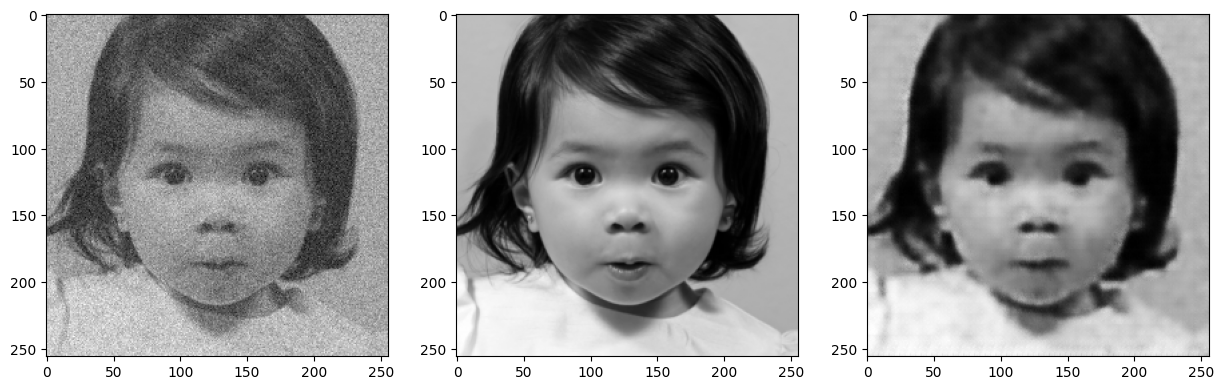

(1, 256, 256)


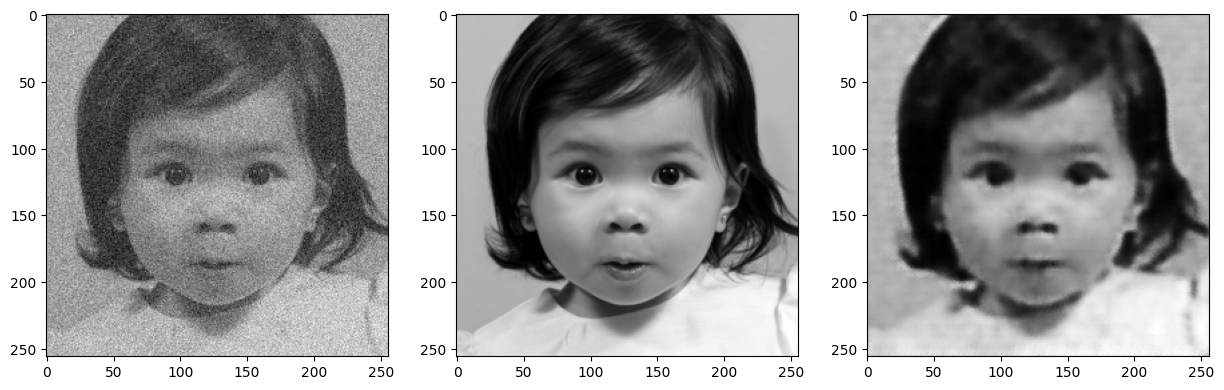

(1, 256, 256)


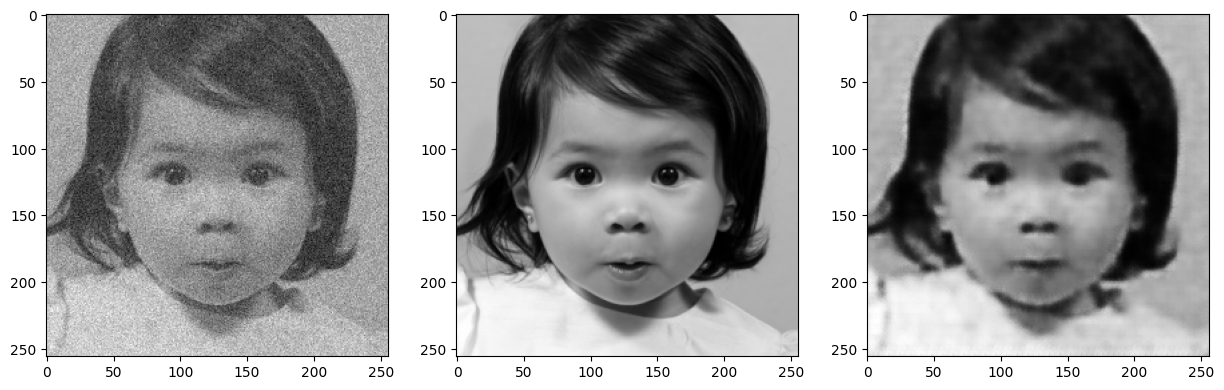

(1, 256, 256)


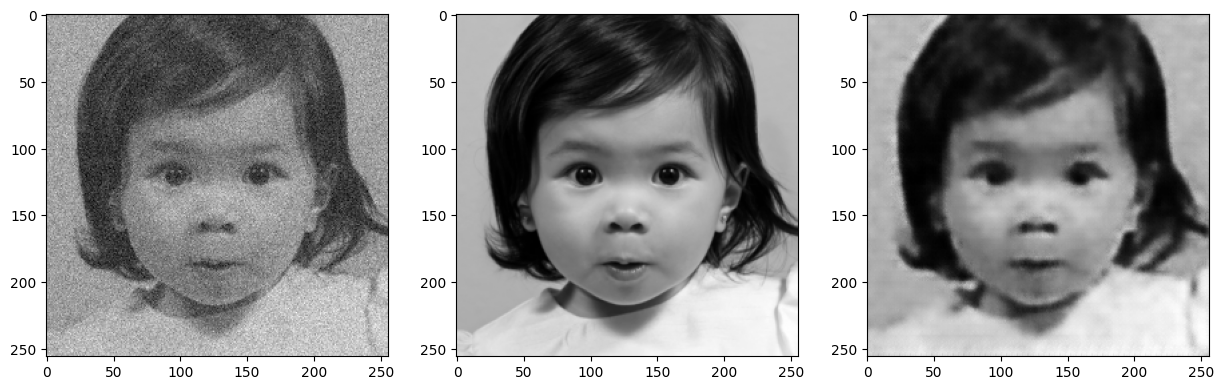

(1, 256, 256)


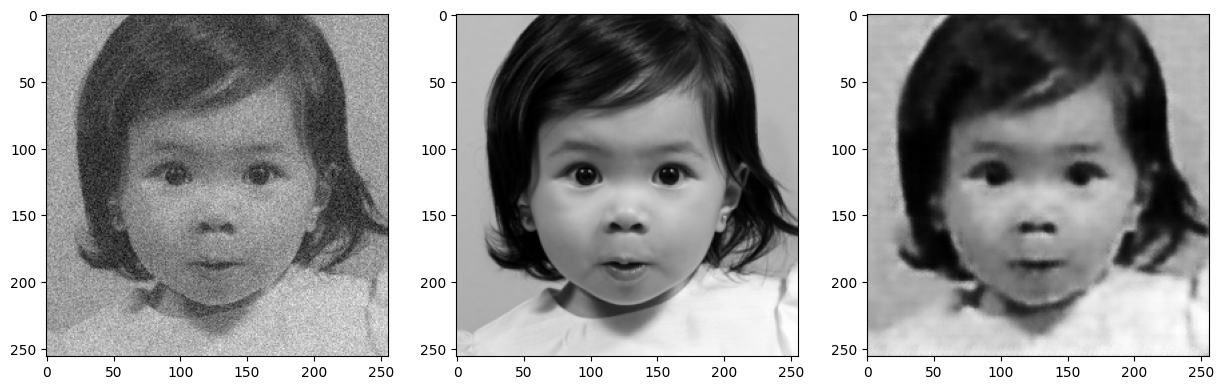

(1, 256, 256)


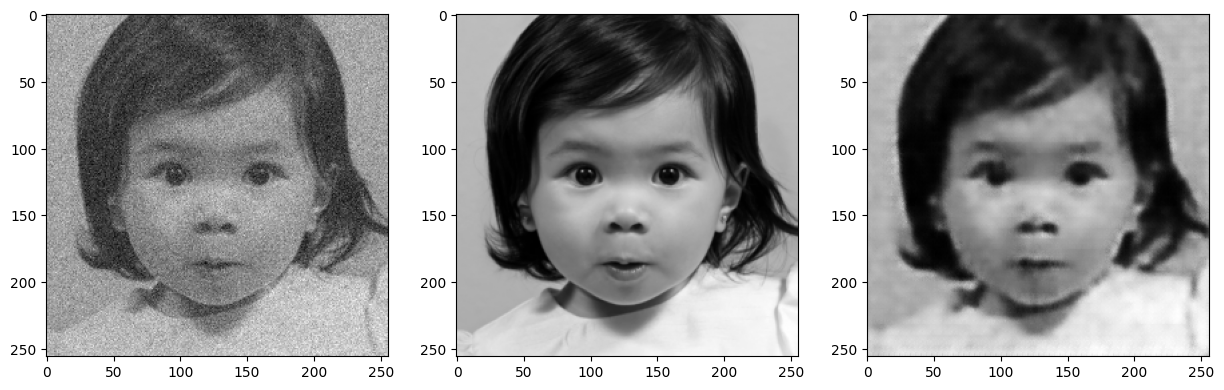

(1, 256, 256)


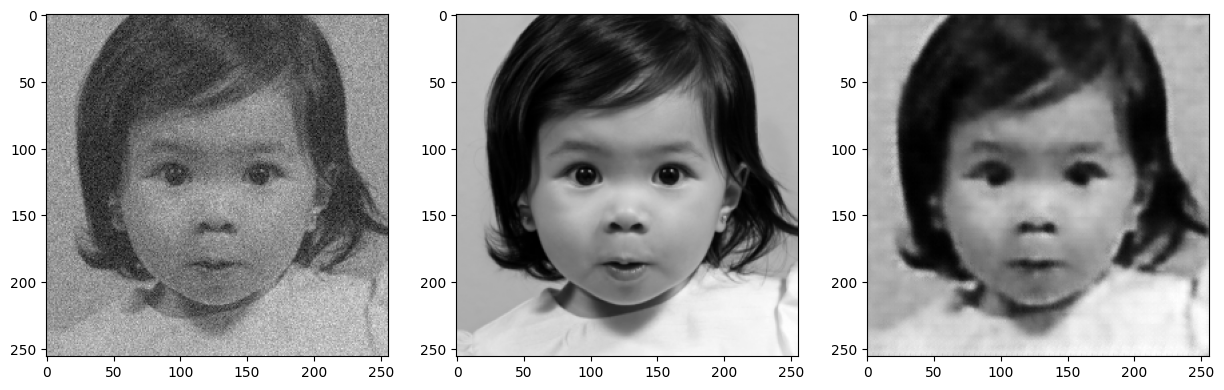

(1, 256, 256)


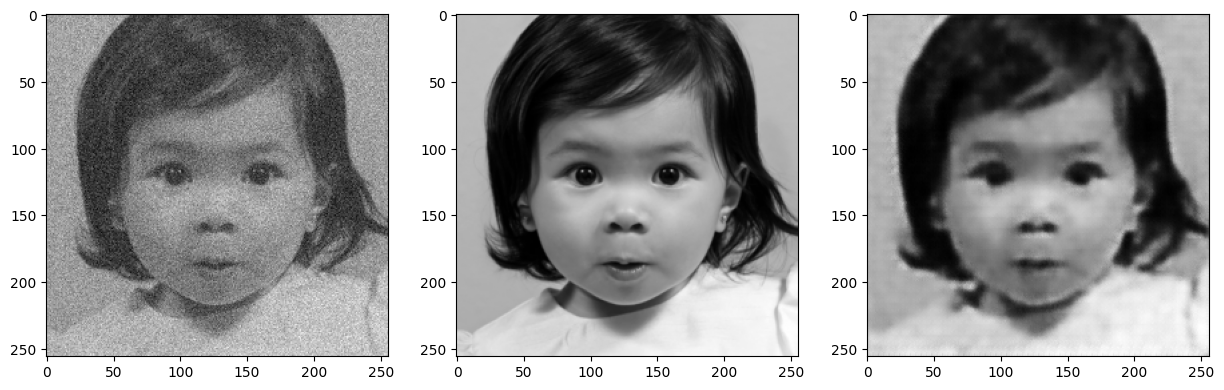

(1, 256, 256)


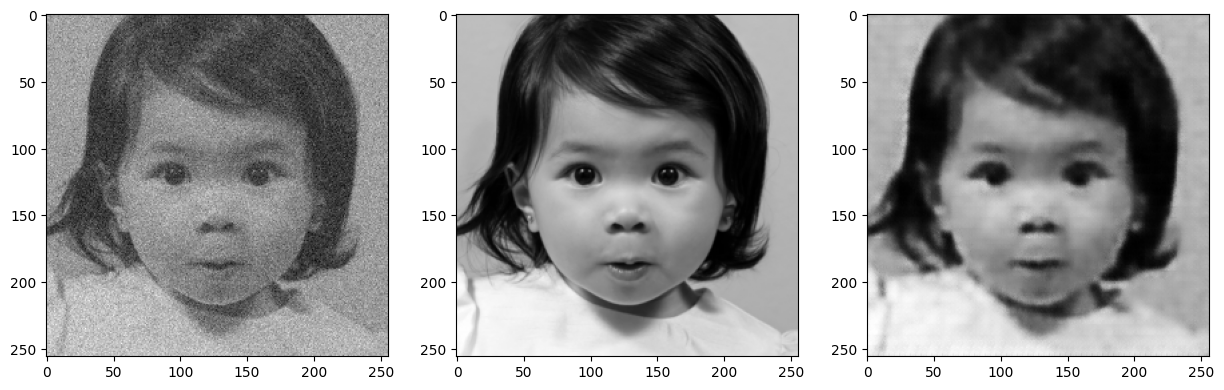

(1, 256, 256)


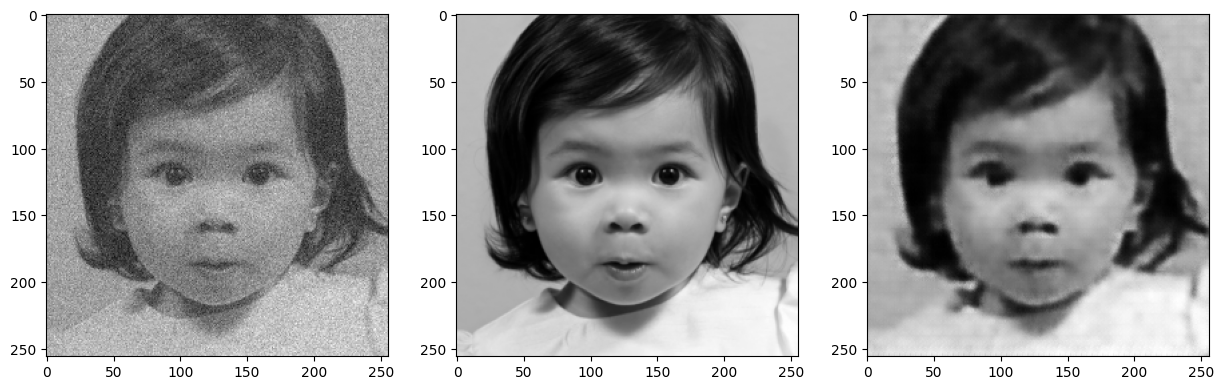

In [26]:
# confirms the random probabilistic nature of transforms
for i in range(10):
    predict(3, model, device, test_set)

layer: 0, shape of w: (32, 3, 3, 3)


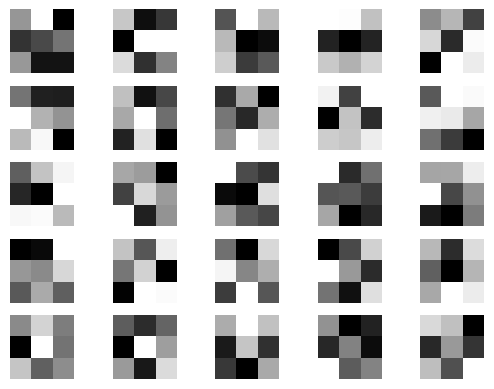

layer: 4, shape of w: (64, 32, 3, 3)


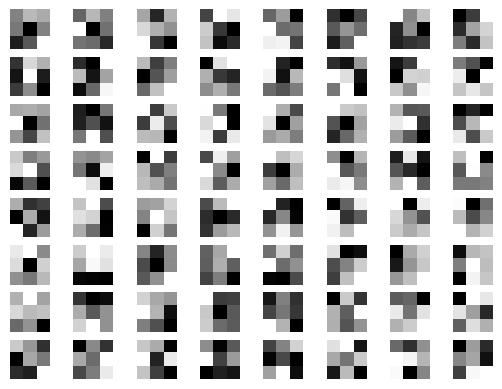

layer: 7, shape of w: (128, 64, 3, 3)


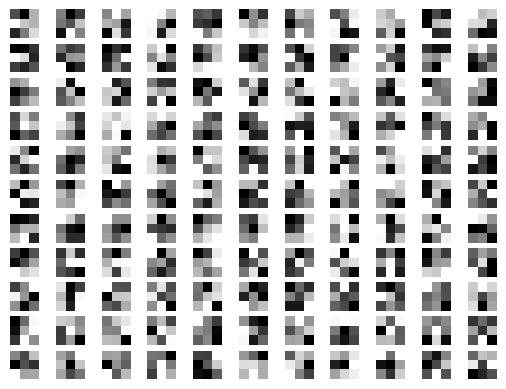

layer: 0, shape of w: (128, 64, 3, 3)


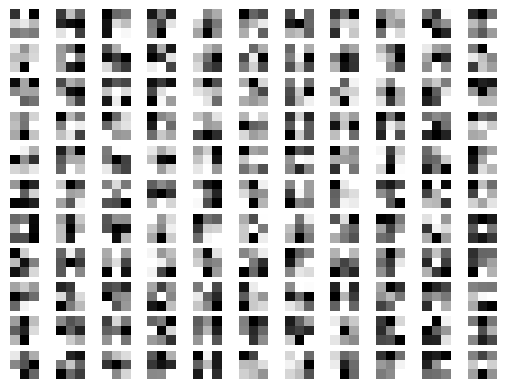

layer: 2, shape of w: (64, 32, 3, 3)


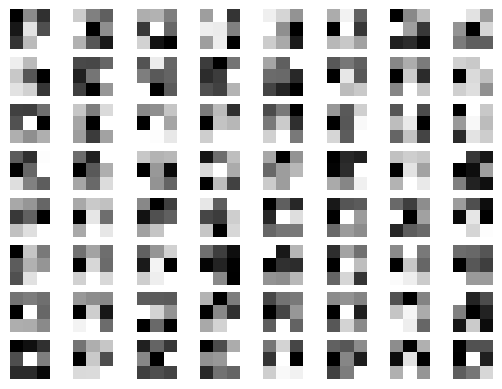

layer: 5, shape of w: (32, 3, 3, 3)


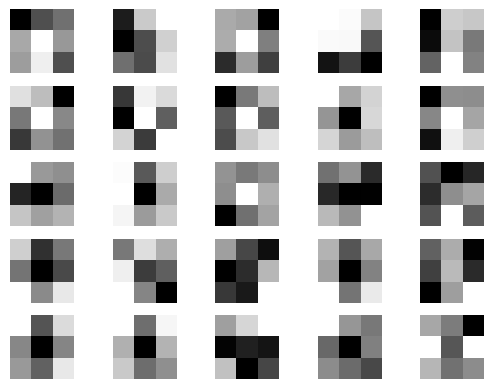

In [ ]:
# visualising kernels using matplotlib
for j, encoder_layer in enumerate(model.encoder.children()):
    if isinstance(encoder_layer, nn.Conv2d):
        w = encoder_layer.weight.data.cpu().numpy()
        print(f'layer: {j}, shape of w: {w.shape}')
        w_min = np.min(w)
        w_max = np.max(w)
        fig, ax = plt.subplots(
            ncols = int(np.sqrt(w.shape[0])),
            nrows = int(np.sqrt(w.shape[0]))
        )
        plt.tick_params(
            left = True,
            bottom = True,
            labelleft = True,
            labelbottom = True
        )
        w = (w - w_min) / (w_max - w_min)
        for i, ax in enumerate(ax.flat):
            ax.imshow(w[i][2], cmap='gray')
            ax.axis('off')
        plt.show()

for j, decoder_layer in enumerate(model.decoder.children()):
    if isinstance(decoder_layer, nn.ConvTranspose2d):
        w = decoder_layer.weight.data.cpu().numpy()
        print(f'layer: {j}, shape of w: {w.shape}')
        w_min = np.min(w)
        w_max = np.max(w)
        fig, ax = plt.subplots(
            ncols = int(np.sqrt(w.shape[0])),
            nrows = int(np.sqrt(w.shape[0]))
        )
        plt.tick_params(
            left = True,
            bottom = True,
            labelleft = True,
            labelbottom = True
        )
        w = (w - w_min) / (w_max - w_min)
        for i, ax in enumerate(ax.flat):
            ax.imshow(w[i][1], cmap='gray')
            ax.axis('off')
        plt.show()


torch.Size([1, 3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([1, 128, 32, 32])
(1, 32, 32)


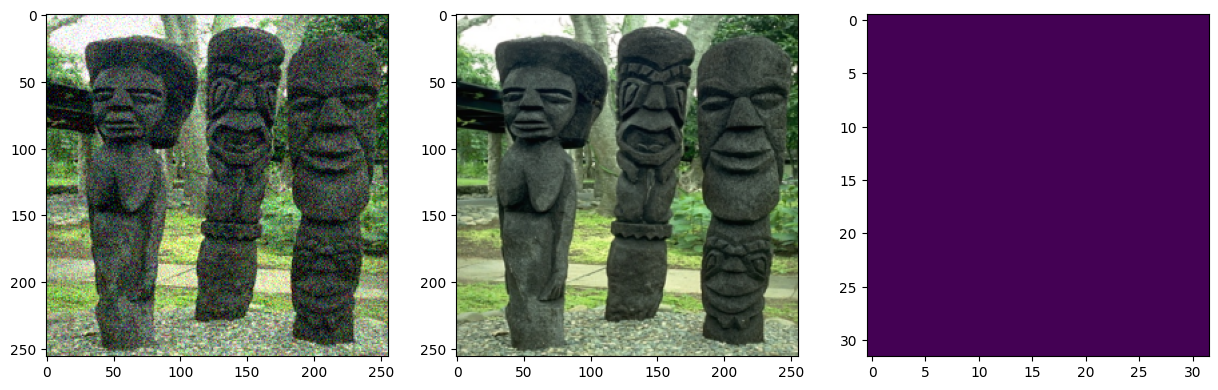

In [ ]:
# attempt to access outputs of intermediate layers ( specifically the first layer ouptut and latent space representation )
input, target = train_set[0]
print(input.unsqueeze(0).shape)
print(target.shape)
prediction = model.encoder(input.unsqueeze(0))

print(prediction.shape)
imshow_side_by_side(input.cpu(), target.cpu(), prediction[:, 3:4, :, :].cpu())
